In [86]:
import pandas as pd
train= pd.read_csv('E:/competionfile/oppo/data/train_0.792.csv')
test = pd.read_csv('E:/competionfile/oppo/data/vali_0.792.csv')
train_prefix_count_dict = train.groupby('prefix')['prefix'].count()
# train = train[ train['prefix'].astype(str).map( lambda x : train_prefix_count_dict[x] if x != 'nan' else 0 ) > 2  ]
# test = test[ test['prefix'].astype(str).map( lambda x : train_prefix_count_dict.get(x,0)) > 0 ]
train_data = train
test_data  = test
co_list = [ 'prefix', 'query_prediction', 'title', 'tag']
train_data = train.drop(co_list , axis = 1 )
test_data = test.drop(co_list, axis = 1 )


train_X_data = train_data.drop(['label'],axis=1)
train_Y_data = train_data['label']
test_X_data = test_data.drop(['label'],axis=1)
vali_data = test_data['label']
pd.set_option('display.max_columns',55)

In [42]:
# train['prefix'].astype(str).map( lambda x : train_prefix_count_dict[x] if x != 'nan' else 0 )

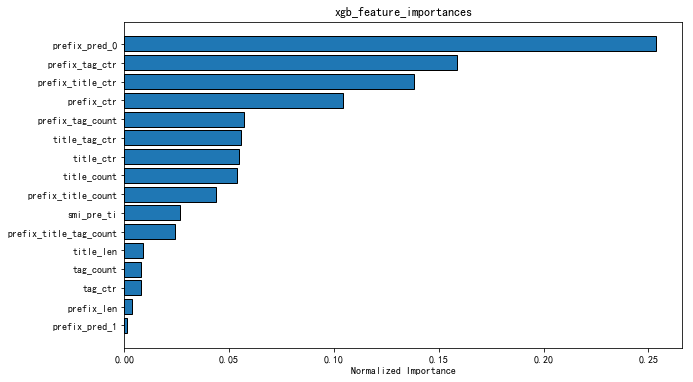

xgb_predict
             precision    recall  f1-score   support

          0  0.80688092 0.88393710 0.84365316     31414
          1  0.76605711 0.64239978 0.69880012     18585

avg / total  0.79170641 0.79415588 0.78981021     49999



d:\Users\tkhoon\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [87]:
#用xgb跑一下
from pylab import mpl
from matplotlib import pyplot as plt
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
def plot_feature_importance(df,title):
        """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
        df = df.sort_values('importance',ascending = False,).reset_index()
        df['importance_normalized'] = df['importance']/df['importance'].sum()
        
        plt.figure(figsize=(10,6))
        ax = plt.subplot()
        
        #取前15个feature
        ax.barh(list(reversed(list(df.index[:]))), df['importance_normalized'], align = 'center', edgecolor = 'k')
        
        ax.set_yticks(list(reversed(list(df.index[:]))))
        ax.set_yticklabels(df['feature'])
        
        plt.xlabel('Normalized Importance')
        plt.title(title)
        
        plt.show()
        
        return df
import xgboost as xgb
xgb =  xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=9, min_child_weight=5, missing=None, n_estimators=10,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=0,
       subsample=0.8)
model = xgb.fit(train_X_data,train_Y_data,eval_metric='auc')
feature_importance_values = model.feature_importances_
features = list(train_X_data.columns)

xgb_feature_importances = pd.DataFrame({'feature':features,'importance':feature_importance_values})

plot_feature_importance(xgb_feature_importances,'xgb_feature_importances')
from sklearn.metrics import classification_report
xgb_predict_label = model.predict(test_X_data)
print('xgb_predict') 
print(classification_report(vali_data,xgb_predict_label,digits=8))

In [11]:
train_data.shape

AttributeError: 'Dataset' object has no attribute 'shape'

In [84]:
from sklearn.metrics import f1_score
import lightgbm as lgb
params = {'metric': 'l1',
          'boosting_type': 'gbdt',
          'max_depth':8,
          'num_leaves':300,
          'num_threads':4,
          'objective':'binary',
          'bagging_fraction':0.5,
          # 'bagging_freq':1,
          'learning_rate' : 0.001,
          'min_data_in_leaf' : 5,
#           'min_data_per_group' : 1,
          # 'weight' : ''
          }

def myFeval(   preds, train):
#     aa = pd.Series(train.get_label()).map( lambda x: 1 if x >= 0.5 else 0 )
#     print()
    score = f1_score(train.get_label(),pd.Series(preds).map( lambda x: 1 if x >= 0.5 else 0 ))
    return 'myFeval',score,False
train_data = lgb.Dataset( train_X_data , train_Y_data ,free_raw_data=False ,  )
test_data = lgb.Dataset( test_X_data , vali_data , reference= train_data )
gbm = lgb.train(params,train_data,valid_sets=test_data,num_boost_round=5,feval = myFeval )

from sklearn.metrics import classification_report
xgb_predict_label = gbm.predict(test_X_data )
xgb_predict_label = pd.Series( xgb_predict_label  ).map(lambda x : 1 if x>= 0.5 else 0)
print('xgb_predict') 
print(classification_report(vali_data,xgb_predict_label,digits=8))

[1]	valid_0's l1: 0.372302	valid_0's myFeval: 0.711415
[2]	valid_0's l1: 0.372898	valid_0's myFeval: 0.711321
[3]	valid_0's l1: 0.373491	valid_0's myFeval: 0.711219
[4]	valid_0's l1: 0.374086	valid_0's myFeval: 0.711125
[5]	valid_0's l1: 0.37468	valid_0's myFeval: 0.711269
xgb_predict
             precision    recall  f1-score   support

          0  0.82169146 0.85640160 0.83868755     31414
          1  0.73861398 0.68587571 0.71126859     18585

avg / total  0.79081094 0.79301586 0.79132498     49999



In [22]:
##取出验证集中的老词
test_old = test[ test['prefix'].astype(str).map( lambda x : train_prefix_count_dict.get(x,0) ) > 0  ]

In [25]:
xgb_predict_label.to_csv('E:/competionfile/oppo/result/old_new_split_old.csv',index=False)

In [38]:
##将测试集中的数据分为新老
import pandas as pd
# train_data = pd.read_csv('E:/competionfile/oppo/new/oppo_round1_train_20180929/oppo_round1_train_20180929.txt',names=['prefix','query_prediction','title','tag','lable'],header=None)
# testAdata  = pd.read_csv('E:/competionfile/oppo/data/test_data_0.792.csv')
# testAdata_orignal = pd.read_csv('E:/competionfile/oppo/new/oppo_round1_train_20180929/oppo_round1_test_A_20180929.txt',names=[0,1,2,3],header=None,)
# train_data = pd.read_table('E:/competionfile/oppo/new/oppo_round1_train_20180929/oppo_round1_train_20180929.txt',names=[0,1,2,3,4],header=None,encoding='utf8').astype(str)
# testAdata_orignal  = pd.read_table('E:/competionfile/oppo/new/oppo_round1_train_20180929/oppo_round1_test_A_20180929.txt',names=[0,1,2,3],header=None,encoding='utf8')
# testAdata_orignal.columns = ['prefix','query_prediction','title','tag']
train_data.columns = ['prefix','query_prediction','title','tag','label']

In [79]:
# testAdata_orignal

In [80]:

# train_prefix_count_dict = train_data.groupby('prefix')['prefix'].count()
# testAdata_old = testAdata[ testAdata_orignal['prefix'].astype(str).map( lambda x : train_prefix_count_dict.get(x,0) ) > 0  ]
# testAdata_orignal_old = testAdata_orignal[ testAdata_orignal['prefix'].astype(str).map( lambda x : train_prefix_count_dict.get(x,0) ) > 0  ]
# testAdata_orignal_new = testAdata_orignal[ testAdata_orignal['prefix'].astype(str).map( lambda x : train_prefix_count_dict.get(x,0) ) == 0  ]

testAdata_orignal_old.to_csv('E:/competionfile/oppo/data/data_split/testAdata_orignal_old.csv')
testAdata_orignal_new.to_csv('E:/competionfile/oppo/data/data_split/testAdata_orignal_new.csv')


In [61]:
# testAdata_old_lgb_predict_label = gbm.predict( testAdata_old )

In [ ]:
print(len(testAdata_old_lgb_predict_label),len())

In [81]:
# testAdata_old
testAdata_orignal_old['result'] = testAdata_old_lgb_predict_label

d:\Users\tkhoon\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [76]:
# pd.set_option('display.max_rows',1000)
# testAdata_orignal_old

In [82]:
testAdata_orignal_old['result'].to_csv('E:/competionfile/oppo/result/testAdata_old_lgb_predict_label.csv')